In [91]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [92]:
training_set = pd.read_csv("dataset/train.csv")

In [93]:
training_set

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire
...,...,...
5978,image2494.jpg,Food
5979,image8015.jpg,Attire
5980,image4975.jpg,Food
5981,image1222.jpg,Food


In [94]:
training_imgs = ["{}".format(x) for x in list(training_set.Image)]

In [95]:
unique_classes = training_set['Class'].unique()
unique_classes

array(['Food', 'misc', 'Attire', 'Decorationandsignage'], dtype=object)

In [96]:
map_dict = {'Food':'0', 'misc':'1', 'Attire':'2', 'Decorationandsignage':'3'}
training_set['Class'] =training_set['Class'].map(map_dict)
training_set

,Image,Class
0,image7042.jpg,0
1,image3327.jpg,1
2,image10335.jpg,2
3,image8019.jpg,0
4,image2128.jpg,2
...,...,...
5978,image2494.jpg,0
5979,image8015.jpg,2
5980,image4975.jpg,0
5981,image1222.jpg,0


In [97]:
train_dataGen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
train_generator = train_dataGen.flow_from_dataframe(
                                        dataframe = training_set,
                                        directory="/home/etg-saibhargav/Documents/hackerearth/Gala images/dataset/Train Images",x_col="Image",
                                        y_col="Class", 
                                        class_mode="categorical",
                                        target_size=(128,128), 
                                        batch_size=100)
validation_dataGen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_dataGen.flow_from_dataframe(
                                        dataframe = training_set,
                                        directory="/home/etg-saibhargav/Documents/hackerearth/Gala images/dataset/Train Images",x_col="Image",
                                        y_col="Class", 
                                        class_mode="categorical",
                                        target_size=(128,128), 
                                        batch_size=100)

Found 5983 validated image filenames belonging to 4 classes.
Found 5983 validated image filenames belonging to 4 classes.


In [98]:
classifier = Sequential()

#First Convolutional layer
classifier.add(Conv2D(filters = 56,kernel_size = (4,4), activation = 'relu', input_shape = (128,128,3)))
classifier.add(MaxPooling2D(pool_size = (4,4)))

#second Convolutional layer
classifier.add(Conv2D(32,(4,4),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (4,4)))

#Flattening
classifier.add(Flatten())
#Hidden Layer
classifier.add(Dense(units = 128, activation = 'relu'))

#Output Layer
classifier.add(Dense(units = 4 , activation = 'softmax'))

In [99]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


classifier.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 125, 125, 56)      2744      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 56)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        28704     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_10 (Dense)             (None, 4)                

In [100]:
from livelossplot.keras import PlotLossesCallback


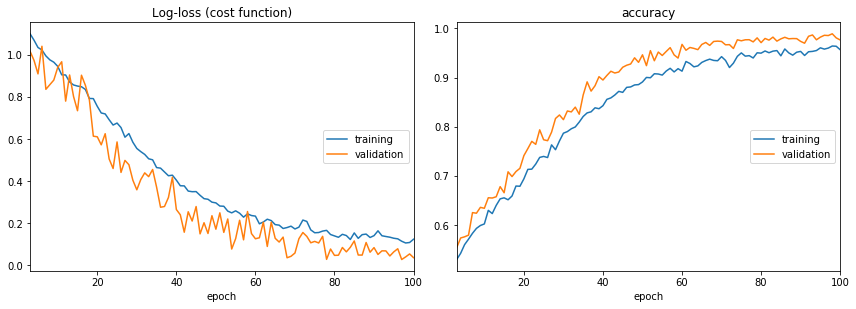

Log-loss (cost function):
training   (min:    0.106, max:    1.263, cur:    0.123)
validation (min:    0.027, max:    1.154, cur:    0.036)

accuracy:
training   (min:    0.415, max:    0.964, cur:    0.957)
validation (min:    0.491, max:    0.989, cur:    0.977)


In [101]:
classifier.fit_generator(train_generator, validation_data=validation_generator,epochs = 100, 
                         steps_per_epoch=len(train_generator.filenames) // 100,
                         validation_steps=len(train_generator.filenames) // 100,
                         callbacks=[PlotLossesCallback()] )

In [102]:

model_json = classifier.to_json()
with open('autotag_gala.json', 'w') as json_file:
    json_file.write(model_json)

In [103]:
reverse_map = {0:'Food', 1:'misc', 2:'Attire',3:'Decorationandsignage'}

In [147]:
test_generator.reset()
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        "/home/etg-saibhargav/Documents/hackerearth/Gala images/dataset/Test Images/",
        target_size=(128, 128),class_mode="categorical",
        shuffle=False,batch_size=1)
pred=classifier.predict_generator(test_generator, steps=len(test_generator), verbose=1)
pred

Found 3219 images belonging to 1 classes.
3219/3219 [==============================] - 13s 4ms/step


array([[1.67102944e-02, 1.66372687e-03, 9.77358580e-01, 4.26746299e-03],
       [9.99999881e-01, 7.63262804e-08, 2.69909162e-09, 1.01267545e-08],
       [6.35620090e-04, 3.28004837e-01, 8.10998143e-04, 6.70548499e-01],
       ...,
       [5.18730712e-06, 9.67689573e-08, 9.99994636e-01, 7.94846713e-08],
       [2.76918828e-01, 2.82204477e-04, 6.31215632e-01, 9.15833786e-02],
       [1.10802464e-02, 9.89976525e-06, 9.88909900e-01, 1.09422444e-08]],
      dtype=float32)

In [152]:
# Get classes by np.round
cl = np.round(pred)
cl = cl.astype(int)
# Get filenames (set shuffle=false in generator is important)
filenames=test_generator.filenames
#cl.astype(int)
cl

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [183]:

predict_class = np.where(cl[:,]== 1)
series = pd.Series(predict_class[1])
series

0       2
1       0
2       3
3       1
4       1
       ..
3133    2
3134    3
3135    2
3136    2
3137    2
Length: 3138, dtype: int64

In [181]:
# Data frame
results=pd.DataFrame({"Image":filenames, "Class": np.where(cl[:,]== 1)})
results['Class'].unique()

ValueError: array length 3219 does not match index length 1

In [75]:
from keras.preprocessing import image

Y_pred = []
test_set = pd.read_csv('dataset/test.csv')
with open('submission.csv', 'w')as f:
    f.write('Image,Class'+ '\n')
    for i in range(len(test_set)):
      

      img = image.load_img(path= '/home/etg-saibhargav/Documents/hackerearth/Gala images/dataset/Test Images/'+ test_set.Image[i],target_size=(128,128,3))
      img_tensor = image.img_to_array(img)
      img_tensor = np.expand_dims(img_tensor, axis=0)
      img_tensor /= 255.
      img_class = classifier.predict_classes(img_tensor)

      prediction = img_class[0]
      value = test_set.Image[i]+ ',' + reverse_map[prediction]+ '\n'
      f.write(value)
      Y_pred.append(prediction)

In [76]:
test_df = pd.read_csv('dataset/test.csv')